In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle

from sklearn.metrics import classification_report, roc_curve, precision_recall_curve
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_curve, precision_recall_curve,roc_auc_score, f1_score, confusion_matrix
from imblearn.over_sampling import SMOTE


%matplotlib inline

In [ ]:
joint_df = pd.read_csv(r"dataset\Joint_clean_ML.csv")

In [ ]:
X = joint_df.drop(columns = {'loan_status'})
Y = joint_df['loan_status']

In [ ]:
# Splitting Dataset into Test & Train

target_col = 'loan_status'

#feature space
X_train = joint_df.drop(columns=[target_col])
X_test = joint_df.drop(columns=[target_col])

#target variable
y_train = joint_df[target_col]
y_test = joint_df[target_col]

In [ ]:
def fit_score_clf(clf, X_train, y_train, X_test, y_test, name='clf'):
    """
    fits a classifer from sklearn and returns a dataframe
    clf(sklearn): classifier
    X_train(numpy): train features
    y_train(numpy): predictions row vector
    X_test(numpy): test features
    y_test(numpy): ground truth row vector
    name(string): name of classifier
    
    """
    #fit to train data
    clf.fit(X_train, y_train)
    #make predictions
    y_pred = clf.predict(X_test)
    #make dataframe from report
    clf_report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))
    #add clf name as column
    clf_report['clf'] = name
    
    return clf_report

In [ ]:
gbtree = GradientBoostingClassifier(learning_rate=0.1, n_estimators = 100)

gbtree_report = fit_score_clf(gbtree, X_train, y_train, X_test, y_test, name='gbtree')
gbtree_report.head()

,0,1,accuracy,macro avg,weighted avg,clf
precision,0.888889,0.870344,0.870345,0.879616,0.872749,gbtree
recall,0.000576,0.999989,0.870345,0.500282,0.870345,gbtree
f1-score,0.001150,0.930673,0.870345,0.465912,0.810095,gbtree
support,13899.000000,93247.000000,0.870345,107146.000000,107146.000000,gbtree


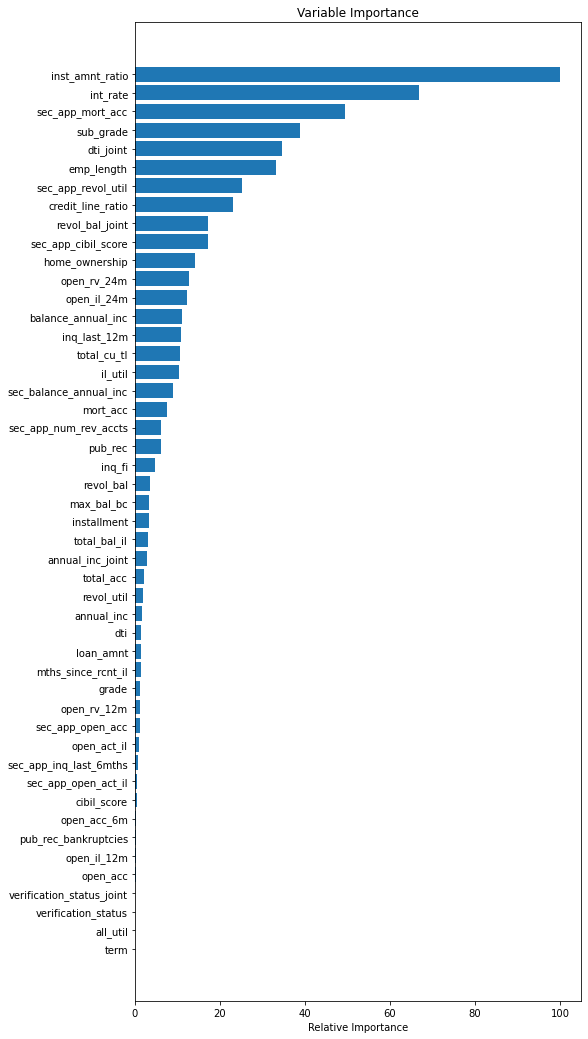

In [ ]:
feature_importance = gbtree.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
# plt.subplot(1, 2, 2)
plt.figure(figsize=(8, 18))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.keys()[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [ ]:
keep_columns=['balance_annual_inc','home_ownership','total_bal_il' , 'sec_app_cibil_score',
       'sec_app_revol_util','dti_joint','sub_grade','sec_app_mort_acc',
       'int_rate','inst_amnt_ratio','term','sec_balance_annual_inc','inq_last_12m']
select_X_train=X_train[keep_columns]
select_X_test=X_test[keep_columns]

In [ ]:
[select_X_train.shape , y_train.shape]

[(107146, 13), (107146,)]

In [ ]:
#define the param grid
# Parameters of pipelines can be set using ‘__’ separated para
clf_grid = {
    "gbtree__max_depth":[3,5,8],
    'gbtree__learning_rate': [0.01,0.05,0.1],
    'gbtree__n_estimators' : [100,500,1000],
    }

#define the pipeline
model_pipe = Pipeline([('gbtree', GradientBoostingClassifier())])

#define the classifer
clf = GridSearchCV(model_pipe,
                   clf_grid,
                   n_jobs=-1,
                   cv=4, 
                   verbose=50, 
                   scoring='roc_auc')


#fit to training data
clf.fit(select_X_train, y_train)

Fitting 4 folds for each of 27 candidates, totalling 108 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   50.8s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   51.5s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   51.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   52.0s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  8

GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('gbtree',
                                        GradientBoostingClassifier())]),
             n_jobs=-1,
             param_grid={'gbtree__learning_rate': [0.01, 0.05, 0.1],
                         'gbtree__max_depth': [3, 5, 8],
                         'gbtree__n_estimators': [100, 500, 1000]},
             scoring='roc_auc', verbose=50)

In [ ]:
print("Best model parameters: \n")
print(clf.best_params_ )
print("Best model score: \n")
print(clf.best_score_)

Best model parameters: 

{'gbtree__learning_rate': 0.1, 'gbtree__max_depth': 3, 'gbtree__n_estimators': 1000}
Best model score: 

0.6438138466659256


In [ ]:
y_pred = clf.predict(select_X_test)
confusion_matrix(y_test, y_pred)

array([[  376, 13523],
       [   25, 93222]], dtype=int64)

In [ ]:
f1_gb = f1_score(y_test, y_pred)

print("f1_gb (binary): {}\n".format(f1_gb))
print(classification_report(y_test,y_pred))

f1_gb (binary): 0.9322572902916118

              precision    recall  f1-score   support

           0       0.94      0.03      0.05     13899
           1       0.87      1.00      0.93     93247

    accuracy                           0.87    107146
   macro avg       0.91      0.51      0.49    107146
weighted avg       0.88      0.87      0.82    107146



In [ ]:
gb_auc = roc_auc_score(y_test, clf.predict_proba(select_X_test)[:,1])
print("gb_auc: {}".format(gb_auc))

gb_auc: 0.7713642519657531


In [ ]:
#define location to save trained model
save_model_dir = os.path.join('gb_cv_compact_joint.pkl')
print("Saving model at: {}".format(save_model_dir))

#save the model
with open(save_model_dir, 'wb') as handle:
    pickle.dump(clf,
                handle)

Saving model at: gb_cv_compact_joint.pkl


In [ ]:
select_X_train=X_train[keep_columns].values
select_X_test=X_test[keep_columns].values

In [ ]:
y_train=y_train.values

In [ ]:
from tqdm import tqdm

auc_arr = []
for _ in tqdm(range(100)):
    idx = np.random.choice(np.arange(len(select_X_train)), 8000, replace=True)
    X_temp = select_X_train[idx]
    y_temp = y_train[idx]
        
    #instantiate classifier
    clf=GradientBoostingClassifier(learning_rate=0.01, n_estimators = 1000,max_depth=3)
    #fit to new data
    clf.fit(X_temp, y_temp)
    
    #predictions and scoring
    score = roc_auc_score(y_test, clf.predict_proba(select_X_test)[:,1])
    auc_arr.append(score)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [34:13<00:00, 20.53s/it]


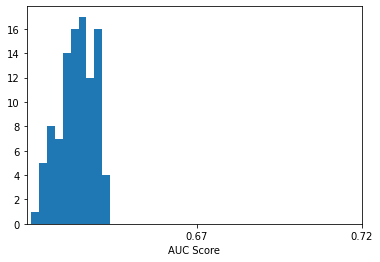

In [ ]:
plt.hist(auc_arr)
plt.xlabel("AUC Score")
plt.xticks(np.arange(0.67, 0.77, 0.05))
plt.savefig('auc_632_sampling_joint.png')
plt.show()